In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

[]


In [2]:
import glob
from PIL import Image
import numpy as np
import glob
all_images=[]
all_labels=[]
filenames=[]
ages=[]
img_size=(80,100)
for f in glob.glob('d:\\data\\xray\\**\\*.jpg', recursive=True):
    #               0    1      2    3  4
    arr=f.split('\\')
    arr2=arr[3].split("_")
    if arr2[1]=='M':
        img = Image.open(f)
        filenames.append(arr[-1])
        img_resize = img.resize((img_size[0], img_size[1]))
        all_images.append(img_resize)
        age=int(arr2[2].replace('yr',''))
        ages.append(age)

In [3]:
filenames[:10]

['332_M.jpg',
 '333_M.jpg',
 '334_M.jpg',
 '335_M.jpg',
 '336_M.jpg',
 '337_M.jpg',
 '338_M.jpg',
 '339_M.jpg',
 '340_M.jpg',
 '341_M.jpg']

In [4]:
items=list(zip(filenames,ages,all_images))
items[:10]

[('332_M.jpg', 10, <PIL.Image.Image image mode=RGB size=80x100>),
 ('333_M.jpg', 10, <PIL.Image.Image image mode=RGB size=80x100>),
 ('334_M.jpg', 10, <PIL.Image.Image image mode=RGB size=80x100>),
 ('335_M.jpg', 10, <PIL.Image.Image image mode=RGB size=80x100>),
 ('336_M.jpg', 10, <PIL.Image.Image image mode=RGB size=80x100>),
 ('337_M.jpg', 10, <PIL.Image.Image image mode=RGB size=80x100>),
 ('338_M.jpg', 10, <PIL.Image.Image image mode=RGB size=80x100>),
 ('339_M.jpg', 10, <PIL.Image.Image image mode=RGB size=80x100>),
 ('340_M.jpg', 10, <PIL.Image.Image image mode=RGB size=80x100>),
 ('341_M.jpg', 10, <PIL.Image.Image image mode=RGB size=80x100>)]

In [5]:
len(all_images)

665

In [6]:
np.array(all_images[0]).shape

(100, 80, 3)

In [7]:
X = np.empty((1, img_size[0], img_size[1], 3))
for img in all_images:
    X = np.vstack((X, np.array(img).reshape(1, img_size[0], img_size[1], 3)))

X.shape

(666, 80, 100, 3)

In [8]:
X = np.delete(X, (0), axis=0)

In [9]:
X.shape

(665, 80, 100, 3)

In [10]:
y = np.array(ages)
y[:10]

array([10, 10, 10, 10, 10, 10, 10, 10, 10, 10])

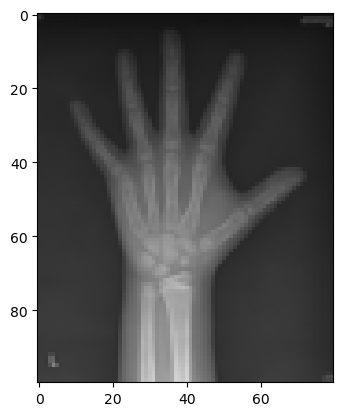

In [11]:
import matplotlib.pyplot as plt
plt.imshow(all_images[0])
plt.show()

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,
                                                    stratify=y, shuffle=True,
                                                    random_state=10)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((532, 80, 100, 3), (133, 80, 100, 3), (532,), (133,))

In [13]:
import pandas as pd
pd.DataFrame(y_train).value_counts()

4     40
5     40
6     40
7     40
8     40
9     40
10    40
11    40
12    40
13    40
14    40
15    36
3     25
16    24
17     7
dtype: int64

In [14]:
X_train=X_train.reshape(-1,img_size[0]*img_size[1]*3)
X_test=X_test.reshape(-1,img_size[0]*img_size[1]*3)

In [15]:
X_train=X_train/255.
X_test=X_test/255.

In [16]:
X_train=X_train.reshape(-1,img_size[0],img_size[1],3)
X_test=X_test.reshape(-1,img_size[0],img_size[1],3)

In [17]:
from tensorflow.keras import utils
y_train_backup=y_train
y_test_backup=y_test

In [18]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
model=Sequential()
model.add(Conv2D(64,(3,3),padding="same", 
        #       out  filter
                 input_shape=X_train.shape[1:],
                 activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64,(3,3),activation="relu"))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64,(3,3),activation="relu"))
model.add(Flatten()) # 1차원으로
model.add(Dense(64,activation="relu"))
model.add(Dense(1)) #회귀분석
model.compile(optimizer="rmsprop",
              loss="mae",metrics=["mae"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 80, 100, 64)       1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 40, 50, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 38, 48, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 19, 24, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 22, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 23936)             0

In [19]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((532, 80, 100, 3), (532,), (133, 80, 100, 3), (133,))

In [26]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint("d:/data/model/xray_m_best.h5", 
                             monitor='val_mae', verbose=1,
                             save_best_only=True, mode='min')
hist = model.fit(X_train, y_train, batch_size=32,
                 validation_split=0.2, epochs=30, 
                 callbacks=[checkpoint])

Epoch 1/30
14/14 [==============================] - ETA: 0s - loss: 2.0508 - mae: 2.0508
Epoch 1: val_mae improved from inf to 1.52436, saving model to d:/data/model\xray_m_best.h5
14/14 [==============================] - 5s 304ms/step - loss: 2.0508 - mae: 2.0508 - val_loss: 1.5244 - val_mae: 1.5244
Epoch 2/30
14/14 [==============================] - ETA: 0s - loss: 1.7506 - mae: 1.7506
Epoch 2: val_mae did not improve from 1.52436
14/14 [==============================] - 4s 305ms/step - loss: 1.7506 - mae: 1.7506 - val_loss: 2.9421 - val_mae: 2.9421
Epoch 3/30
14/14 [==============================] - ETA: 0s - loss: 1.9988 - mae: 1.9988
Epoch 3: val_mae did not improve from 1.52436
14/14 [==============================] - 4s 290ms/step - loss: 1.9988 - mae: 1.9988 - val_loss: 2.8132 - val_mae: 2.8132
Epoch 4/30
14/14 [==============================] - ETA: 0s - loss: 1.7883 - mae: 1.7883
Epoch 4: val_mae did not improve from 1.52436
14/14 [==============================] - 4s 291ms/s

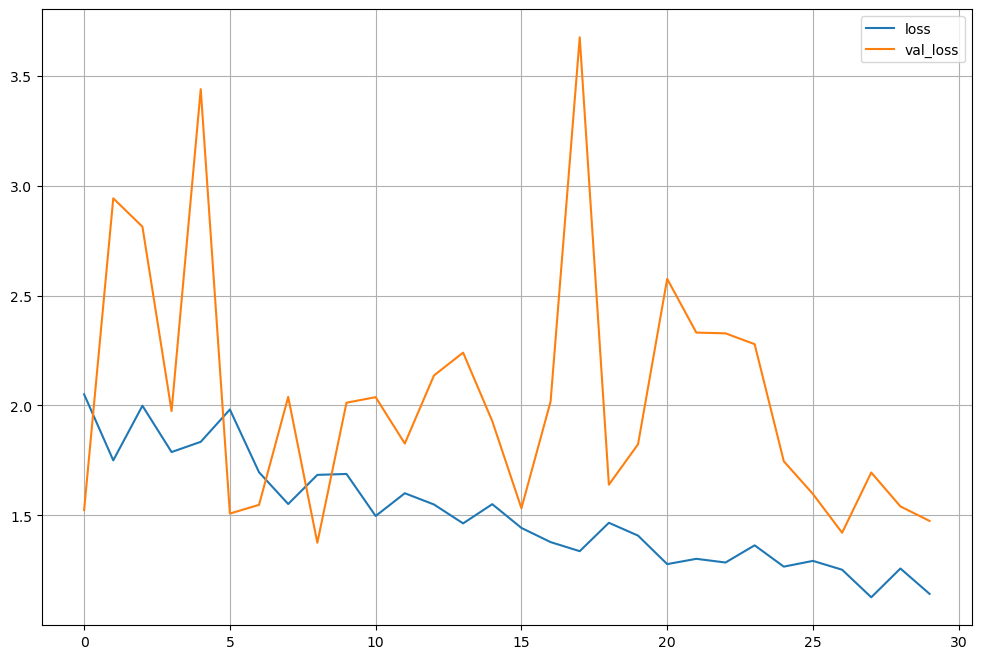

In [27]:
plt.figure(figsize=(12,8))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['loss','val_loss'])
plt.grid()
plt.show()

In [28]:
from tensorflow.keras.models import load_model
model = load_model('d:/data/model/xray_m_best.h5')
scores = model.evaluate(X_train, y_train, verbose=1)
print(scores)

17/17 [==============================] - 1s 61ms/step - loss: 1.1546 - mae: 1.1546
[1.1545501947402954, 1.1545501947402954]


In [29]:
model = load_model('d:/data/model/xray_m_best.h5')
scores = model.evaluate(X_test, y_test, verbose=1)
print(scores)

5/5 [==============================] - 0s 44ms/step - loss: 1.7576 - mae: 1.7576
[1.7576138973236084, 1.7576138973236084]


In [30]:
pred = model.predict(X_test)
pred[:5]

5/5 [==============================] - 0s 50ms/step


array([[ 9.796779 ],
       [ 6.6175475],
       [11.843107 ],
       [12.331361 ],
       [ 3.1372592]], dtype=float32)

In [31]:
y_test[:5]

array([10,  9, 13, 11,  5])